In [1]:
import copy
import math
import struct
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import csv
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode, kurtosis, skew
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
import copy
import warnings
import multiprocessing
import pickle

from scipy.stats import kurtosis
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, plot_confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from joblib import Parallel, delayed

# import tsfel
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

# plt.rcParams["text.usetex"] = True
# font = {"family": "normal", "weight": "bold", "size": 16}

# plt.rc("font", **font)


if os.path.exists("/home/grads/s/sorush.omidvar/CGMDataset/Hoover/"):
    addressPrefix = "/home/grads/s/sorush.omidvar/CGMDataset/Hoover/"

elif os.path.exists("C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/"):
    addressPrefix = "C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/"

elif os.path.exists("C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/"):
    addressPrefix = "C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/"

elif os.path.exists("/Users/sorush/Google Drive/My Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover"):
    addressPrefix = "/Users/sorush/Google Drive/My Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover"

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({"figure.facecolor": "white"})
coreNumber = np.min([multiprocessing.cpu_count(), 64])
pd.set_option("display.max_rows", 500)

# import warnings
# warnings.filterwarnings("ignore")


/home/grads/s/sorush.omidvar/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def pdFormatter(df):
    for counter in range(len(df)):
        tempStr = df.iloc[counter, 1]
        tempVal = int(tempStr[0:2]) * 3600 + int(tempStr[3:5]) * 60 + int(tempStr[6:8])
        tempVal *= 1000
        df.iloc[counter, 1] = tempVal

        tempStr = df.iloc[counter, 2]
        tempVal = int(tempStr[0:2]) * 3600 + int(tempStr[3:5]) * 60 + int(tempStr[6:8])
        tempVal *= 1000
        df.iloc[counter, 2] = tempVal
        if df.iloc[counter, 1] > df.iloc[counter, 2]:
            df.iloc[counter, 2] += 24 * 3600 * 1000
    df.sort_values(by=["Name", "Start", "End"], inplace=True)

    return df


def labelReader(addressPrefix):
    labelFiles = []
    for root, dirs, files in os.walk(addressPrefix, topdown=False):
        for name in files:
            if ".txt" in name:
                labelFiles.append([os.path.join(root, name), name])
    mealTime = []
    sensorTiming = []
    for element in labelFiles:
        nameTemp = element[1]
        nameTemp = nameTemp[: nameTemp.find("-events")]
        with open(element[0], "r+") as txtfile:
            fileData = txtfile.read()
            fileData = fileData.splitlines()
            while "" in fileData:
                fileData.remove("")
            tempStart = fileData[0]
            tempStart = tempStart.split()
            tempStart = tempStart[2]

            tempEnd = fileData[-1]
            tempEnd = tempEnd.split()
            tempEnd = tempEnd[2]

            sensorTiming.append([nameTemp, tempStart, tempEnd])
            for counter in range(1, len(fileData) - 1):
                tempStr = fileData[counter]
                tempStr = tempStr.split()
                mealTime.append([nameTemp, tempStr[1], tempStr[2]])

    dfMeal = pd.DataFrame(mealTime, columns=["Name", "Start", "End"])
    dfMeal = pdFormatter(dfMeal)

    dfTime = pd.DataFrame(sensorTiming, columns=["Name", "Start", "End"])
    dfTime = pdFormatter(dfTime)

    return dfMeal, dfTime


def shimmerReader(element):
    nameTemp = element[1]
    dataList = []
    tempList = []
    with open(element[0], mode="rb") as txtfile:
        fileData = txtfile.read()
        for i in range(int(len(fileData) / 4)):
            if i % 6 == 0 and i != 0:
                tempList.append(nameTemp)
                dataList.append(tempList)
                tempList = []
            tempVal = fileData[i * 4 : (i + 1) * 4]
            tempVal = struct.unpack("f", tempVal)
            tempVal = tempVal[0]
            tempList.append(tempVal)
    txtfile.close()

    dfSensor = pd.DataFrame(dataList, columns=["X", "Y", "Z", "Yaw", "Pitch", "Roll", "Name"])
    dfSensor = dfSensor[["Name", "X", "Y", "Z", "Yaw", "Pitch", "Roll"]]
    del dataList
    return dfSensor


def timeFinder(dfSensor, dfTime):
    dfSensor.insert(1, "Time", float("nan"))
    name = dfSensor["Name"].tolist()
    name = name[0]
    dfTemp = dfTime[dfTime["Name"] == name]

    if len(dfTemp) > 1:
        print("More than one event file for:", name)
        return
    elif len(dfTemp) == 0:
        print("No event file for:", name)
        return
    startTemp = dfTemp["Start"].tolist()
    endTemp = dfTemp["End"].tolist()
    tempTimeStamp = np.linspace(startTemp, endTemp, num=len(dfSensor))
    dfSensor["Time"] = tempTimeStamp
    return dfSensor


def labelExtractor(dfMeal, features):
    dataTotal = []
    for feature in features:
        dataTemp = []
        windowName = feature[-3]
        windowStart = feature[-2]
        windowEnd = feature[-1]
        dfTemp = dfMeal[dfMeal["Name"] == windowName]
        if len(dfTemp) == 0:
            print("skipped", windowName)
            break
        eatingFlag = False
        for counter in range(0, len(dfTemp)):
            if dfTemp.iloc[counter, 1] < windowEnd and dfTemp.iloc[counter, 2] > windowStart:
                eatingFlag = True
                break
        dataTemp.extend(feature[: len(feature) - 3])
        dataTemp.extend([windowName, eatingFlag])
        dataTotal.append(dataTemp)

    return dataTotal


def labelFinder(dfMeals, windowLength, name, start, end):
    dfMeal = dfMeals[dfMeals["Name"] == name]
    eatingFlag = False
    for counter in range(0, len(dfMeal)):
        if dfMeal.iloc[counter]["Start"] <= end - windowLength / 2 and dfMeal.iloc[counter].loc["End"] >= start + windowLength / 2:
            eatingFlag = True
            break
    return eatingFlag


def featureExtractor(df):
    # cfg = tsfel.get_features_by_domain()
    name = df.iloc[0, 0]
    start = df.iloc[:, 1].min()
    end = df.iloc[:, 1].max()
    eatingFlag = df["EatingFlag"].iloc[0]

    f2 = df["X"].abs() + df["Y"].abs() + df["Z"].abs() + 0.0001  # To avoid getting nan for F1
    f2 = np.asarray(f2)
    f1 = df["Yaw"].abs() + df["Pitch"].abs() + df["Roll"].abs()
    f1 = np.asarray(f1)
    f1 = f1 / f2
    featureData = [name, eatingFlag, start, end, np.mean(f1), np.std(f1), np.max(f1) - np.min(f1), np.mean(f2), np.std(f2), np.max(f2) - np.min(f2)]
    # featureData = [
    #     name,
    #     eatingFlag,
    #     start,
    #     end,
    #     np.mean(f1),
    #     np.std(f1),
    #     np.max(f1) - np.min(f1),
    #     np.mean(f2),
    #     np.std(f2),
    #     np.max(f2) - np.min(f2),
    #     df["X"].mean(skipna=True),
    #     df["X"].std(skipna=True),
    #     df["X"].skew(skipna=True),
    #     df["X"].kurtosis(skipna=True),
    #     df["Y"].mean(skipna=True),
    #     df["Y"].std(skipna=True),
    #     df["Y"].skew(skipna=True),
    #     df["Y"].kurtosis(skipna=True),
    #     df["Z"].mean(skipna=True),
    #     df["Z"].std(skipna=True),
    #     df["Z"].skew(skipna=True),
    #     df["Z"].kurtosis(skipna=True),
    #     df["Yaw"].mean(skipna=True),
    #     df["Yaw"].std(skipna=True),
    #     df["Yaw"].skew(skipna=True),
    #     df["Yaw"].kurtosis(skipna=True),
    #     df["Pitch"].mean(skipna=True),
    #     df["Pitch"].std(skipna=True),
    #     df["Pitch"].skew(skipna=True),
    #     df["Pitch"].kurtosis(skipna=True),
    #     df["Roll"].mean(skipna=True),
    #     df["Roll"].std(skipna=True),
    #     df["Roll"].skew(skipna=True),
    #     df["Roll"].kurtosis(skipna=True),
    # ]
    return featureData


def windowMaker(dfSensor, dfMeal):
    windowLength = 60 * 1000
    features = []
    startTime = dfSensor["Time"].min()
    endTime = startTime + windowLength
    while startTime < 24 * 3600 * 1000:
        dfTemp = dfSensor[dfSensor["Time"] >= startTime]
        dfTemp = dfTemp[dfTemp["Time"] < endTime]
        if len(dfTemp) > 40 * 15:
            eatingFlag = labelFinder(dfMeal, windowLength, dfTemp.iloc[0].loc["Name"], dfTemp["Time"].min(), dfTemp["Time"].max())
            dfTemp.insert(8, "EatingFlag", eatingFlag)
            features.append(featureExtractor(dfTemp))
        startTime += windowLength
        endTime += windowLength
    columnList = ["Name", "EatingFlag", "Start", "End", "F1-Mean", "F1-Std", "F1-Range", "F2-Mean", "F2-Std", "F2-Range"]
    # columnList = [
    #     "Name",
    #     "EatingFlag",
    #     "Start",
    #     "End",
    #     "F1-Mean",
    #     "F1-Std",
    #     "F1-Range",
    #     "F2-Mean",
    #     "F2-Std",
    #     "F2-Range",
    #     "X-Mean",
    #     "X-Std",
    #     "X-Skew",
    #     "X-Kurtosis",
    #     "Y-Mean",
    #     "Y-Std",
    #     "Y-Skew",
    #     "Y-Kurtosis",
    #     "Z-Mean",
    #     "Z-Std",
    #     "Z-Skew",
    #     "Z-Kurtosis",
    #     "Yaw-Mean",
    #     "Yaw-Std",
    #     "Yaw-Skew",
    #     "Yaw-Kurtosis",
    #     "Pitch-Mean",
    #     "Pitch-Std",
    #     "Pitch-Skew",
    #     "Pitch-Kurtosis",
    #     "Roll-Mean",
    #     "Roll-Std",
    #     "Roll-Skew",
    #     "Roll-Kurtosis",
    # ]
    features = pd.DataFrame(features, columns=columnList)
    return features


def parallelCall(element, dfMeal, dfTime):
    dfSensor = shimmerReader(element)
    dfSensor = timeFinder(dfSensor, dfTime)
    features = windowMaker(dfSensor, dfMeal)
    return features


def main(addressPrefix):
    shimmerFiles = []
    dfMeal, dfTime = labelReader(os.path.join(addressPrefix, "EVENTfiles"))
    for root, dirs, files in os.walk(os.path.join(addressPrefix, "SHMfiles"), topdown=False):
        for name in files:
            if ".shm" in name:
                shimmerFiles.append([os.path.join(root, name), name[:-4]])
    # shimmerFiles=shimmerFiles[0:20]
    print("The number of core to be used:", coreNumber)
    dfFeatures = Parallel(n_jobs=coreNumber)(delayed(parallelCall)(i, dfMeal, dfTime) for i in tqdm(shimmerFiles))
    # dfFeatures=parallelCall(shimmerFiles[0],dfMeal,dfTime)
    dfFeatures = pd.concat(dfFeatures)
    dfFeatures.sort_values(by=["Name", "Start"])
    dfFeatures.reset_index(drop=True, inplace=True)
    dfFeatures.to_pickle(os.path.join(addressPrefix, "dfFeatures.pkl"))
    return dfFeatures


if os.path.exists(os.path.join(addressPrefix, "dfFeatures.pkl")):
    os.remove(os.path.join(addressPrefix, "dfFeatures.pkl"))
if not os.path.exists(os.path.join(addressPrefix, "dfFeatures.pkl")):
    dfFeatures = main(addressPrefix)


The number of core to be used: 64


100%|██████████| 354/354 [01:51<00:00,  3.18it/s]


SMOTE: False Normal: True Set 0 Roc-Auc: 0.78 Depth: 3 Esti: 150 PosWeig: 17.611178467507276
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=64,
              num_parallel_tree=1, predictor='auto', random_state=20,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=17.611178467507276,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
0.7829192559865417


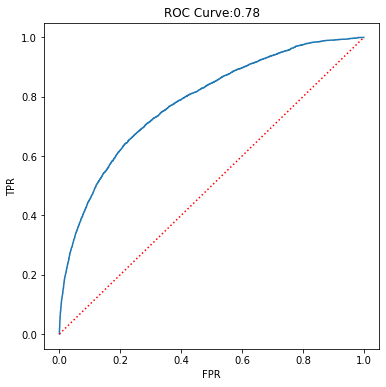

False True 0 ROC= 0.783 Acc= 0.712 Rec= 0.672 Prec= 0.927 F1= 0.814 3 150 0.5 17.611


/home/grads/s/sorush.omidvar/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


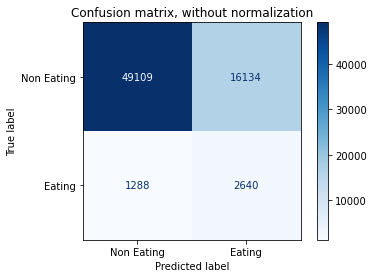

   SMOTEFlag  normalFlag  SetNumber  Roc-Auc-Score  Accuracy  Recall  \
0      False        True          0          0.783     0.712   0.672   

   Precision     F1  MaxDepth  Estimator  Threshold  PosWeight  
0      0.927  0.814         3        150        0.5     17.611  


In [3]:
def modelVisualizer(testData, testLabels, modelBest):
    slidingWindowPrediction = modelBest.predict(testData)
    confMatrix = sklearn.metrics.confusion_matrix(testLabels, slidingWindowPrediction, normalize="all")
    accuracy = sklearn.metrics.accuracy_score(testLabels, slidingWindowPrediction)
    recall = sklearn.metrics.recall_score(testLabels, slidingWindowPrediction)
    precision = sklearn.metrics.precision_score(testLabels, slidingWindowPrediction)

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", "true")]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(modelBest, testData, testLabels, display_labels=["Non Eating", "Eating"], cmap=plt.cm.Blues, normalize=normalize)
        disp.ax_.set_title(title)
        break
    # fig=disp.plot()
    plt.savefig("ClemsonConfMatrix.jpg", format="jpg", dpi=300)
    plt.show()
    return confMatrix


def xgClassifier(xTrain, yTrain, xTest, yTest, randomSeed, normalFlag, SMOTEFlag, reports, setNumber):
    if normalFlag:
        for dimensionCounter in range(xTrain.shape[1]):
            xTest[:, dimensionCounter] -= np.mean(xTrain[:, dimensionCounter])
            xTest[:, dimensionCounter] /= np.std(xTrain[:, dimensionCounter])

            xTrain[:, dimensionCounter] -= np.mean(xTrain[:, dimensionCounter])
            xTrain[:, dimensionCounter] /= np.std(xTrain[:, dimensionCounter])

    stratShuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=randomSeed)
    for trainInd, valInd in stratShuffle.split(xTrain, yTrain):
        xTrain, xVal = xTrain[trainInd, :], xTrain[valInd, :]
        yTrain, yVal = yTrain[trainInd], yTrain[valInd]

    if SMOTEFlag:
        oversample = SMOTE()
        xTrain, yTrain = oversample.fit_resample(xTrain, yTrain)
        posWeights = [1]
    else:
        posWeights = [len(yTrain) / np.sum(yTrain)]

    rocAucScoreBest = -1
    maxDepthBest = -1
    estimatorBest = -1
    posWeightBest = -1
    for maxDepth in np.arange(3, 7, 20):
        for estimator in np.arange(150, 300, 500):
            for posWeight in posWeights:
                clf = xgb.XGBClassifier(n_estimators=estimator, max_depth=maxDepth, objective="binary:logistic", scale_pos_weight=posWeight, random_state=randomSeed, n_jobs=coreNumber, eval_metric="logloss", use_label_encoder=False)
                clf.fit(xTrain, yTrain)
                valPrediction = clf.predict_proba(xVal)
                valPrediction = valPrediction[:, 1]

                rocAucScore = roc_auc_score(yVal, valPrediction, average="weighted")
                print("SMOTE:", SMOTEFlag, "Normal:", normalFlag, "Set", setNumber, "Roc-Auc:", np.round(rocAucScore, 3), "Depth:", maxDepth, "Esti:", estimator, "PosWeig:", posWeight)
                if rocAucScore > rocAucScoreBest:
                    rocAucScoreBest = rocAucScore
                    maxDepthBest = maxDepth
                    estimatorBest = estimator
                    posWeightBest = posWeight
                    modelBest = clf

    print(modelBest)
    f1ScoreBest = -1
    thresholdBest = 0.5
    # for threshold in np.arange(0.2, 0.8, 0.1):
    #     valPrediction = modelBest.predict_proba(xVal)
    #     valPrediction = valPrediction[:, 1]
    #     valPrediction[valPrediction >= threshold] = 1
    #     valPrediction[valPrediction < threshold] = 0

    #     accuracy = sklearn.metrics.accuracy_score(yVal, valPrediction)
    #     recall = sklearn.metrics.recall_score(yVal, valPrediction)
    #     precision = sklearn.metrics.precision_score(yVal, valPrediction)
    #     f1Score = sklearn.metrics.f1_score(yVal, valPrediction, average="weighted")
    #     if f1Score > f1ScoreBest:
    #         thresholdBest = threshold
    #         f1ScoreBest = f1Score

    testPrediction = modelBest.predict_proba(xTest)
    testPrediction = testPrediction[:, 1]

    fpr, tpr, thresholds = roc_curve(yTest, testPrediction, pos_label=1)
    print(roc_auc_score(yTest, testPrediction))
    fig = plt.figure(figsize=(6, 6))
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve:" + str(np.round(roc_auc_score(yTest, testPrediction), 2)))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "r:")
    fig.savefig("ClemsonROC.jpg", format="jpg", dpi=600)
    plt.show()

    rocAucScore = roc_auc_score(yTest, testPrediction)

    testPrediction[testPrediction >= thresholdBest] = 1
    testPrediction[testPrediction < thresholdBest] = 0

    confMatrix = sklearn.metrics.confusion_matrix(yTest, testPrediction)
    accuracy = sklearn.metrics.balanced_accuracy_score(yTest, testPrediction)
    recall = sklearn.metrics.recall_score(yTest, testPrediction)
    precision = sklearn.metrics.precision_score(yTest, testPrediction, average="weighted")
    f1Score = sklearn.metrics.f1_score(yTest, testPrediction, average="weighted")

    print(SMOTEFlag, normalFlag, setNumber, "ROC=", np.round(rocAucScore, 3), "Acc=", np.round(accuracy, 3), "Rec=", np.round(recall, 3), "Prec=", np.round(precision, 3), "F1=", np.round(f1Score, 3), maxDepthBest, estimatorBest, np.round(thresholdBest, 3), np.round(posWeightBest, 3))
    reports.append([SMOTEFlag, normalFlag, setNumber, np.round(rocAucScore, 3), np.round(accuracy, 3), np.round(recall, 3), np.round(precision, 3), np.round(f1Score, 3), maxDepthBest, estimatorBest, np.round(thresholdBest, 3), np.round(posWeightBest, 3)])
    filename = os.path.join(addressPrefix, "HooverModel-" + str(np.round(thresholdBest, 3)) + ".sav")
    pickle.dump(modelBest, open(filename, "wb"))
    confMatrixTest = modelVisualizer(xTest, yTest, modelBest)
    return reports


# def randomForestClassifier(dataList, labelList, randomSeed):
#     trainData, testData, trainLabels, testLabels = train_test_split(dataList, labelList, test_size=0.25, random_state=randomSeed)
#     trainData, valData, trainLabels, valLabels = train_test_split(trainData, trainLabels, test_size=0.33, random_state=randomSeed)
#     oversample = SMOTE()
#     trainData, trainLabels = oversample.fit_resample(trainData, trainLabels)
#     f1Best = 0
#     for treeNum in np.arange(10, 100, 10):
#         for maxDepth in np.arange(3, 10):
#             clf = RandomForestClassifier(n_estimators=treeNum, criterion="entropy", random_state=0, max_depth=maxDepth, n_jobs=coreNumber)
#             clf.fit(trainData, trainLabels)
#             slidingWindowPrediction = clf.predict(valData)
#             accuracy = sklearn.metrics.accuracy_score(valLabels, slidingWindowPrediction)
#             recall = sklearn.metrics.recall_score(valLabels, slidingWindowPrediction)
#             precision = sklearn.metrics.precision_score(valLabels, slidingWindowPrediction)
#             f1 = sklearn.metrics.f1_score(valLabels, slidingWindowPrediction, average="weighted")

#             if f1 > f1Best:
#                 f1Best = f1
#                 maxDepthBest = maxDepth
#                 treeNumBest = treeNum
#                 accuracyBest = accuracy
#                 modelBest = clf
#                 recallBest = recall
#                 precisionBest = precision

#     modelVisualizer(testData, testLabels, modelBest)


# def dataSplitter(normalFlag,randomSeed):


def foldRunnerAux(df, xData, yData, xTrain, yTrain, xTest, yTest):
    tempVal = df["Train"].to_list()
    tempVal = np.asarray(tempVal).astype(int)
    tempVal = tempVal.flatten()
    if len(yTrain) == 0:
        xTrain = xData[tempVal, :]
        yTrain = yData[tempVal]
    else:
        xTrain = np.concatenate((xTrain, xData[tempVal, :]), axis=0)
        yTrain = np.concatenate((yTrain, yData[tempVal]), axis=0)

    tempVal = df["Test"].to_list()
    tempVal = np.asarray(tempVal).astype(int)
    tempVal = tempVal.flatten()
    if len(yTest) == 0:
        xTest = xData[tempVal, :]
        yTest = yData[tempVal]
    else:
        xTest = np.concatenate((xTest, xData[tempVal, :]), axis=0)
        yTest = np.concatenate((yTest, yData[tempVal]), axis=0)

    return xTrain, yTrain, xTest, yTest


def foldRunner(dfData, posXData, posYData, negXData, negYData, setData):
    xTrain = []
    yTrain = []
    xTest = []
    yTest = []

    dfTemp = dfData[dfData["Set"] == setData]
    dfPos = dfTemp[dfTemp["Stat"] == "Pos"]
    xTrain, yTrain, xTest, yTest = foldRunnerAux(dfPos, posXData, posYData, xTrain, yTrain, xTest, yTest)

    dfTemp = dfData[dfData["Set"] == setData]
    dfNeg = dfTemp[dfTemp["Stat"] == "Neg"]
    xTrain, yTrain, xTest, yTest = foldRunnerAux(dfNeg, negXData, negYData, xTrain, yTrain, xTest, yTest)

    return xTrain, yTrain, xTest, yTest


def posNegSeparator(df, statLabel):
    dfTemp = df[df["EatingFlag"] == statLabel]
    yData = dfTemp["EatingFlag"].to_list()
    yData = np.asarray(yData).astype(float)

    dfTemp.drop(columns=["EatingFlag", "Name", "Start", "End"], inplace=True)
    xData = dfTemp.values
    xData = np.asarray(xData).astype(float)
    return xData, yData


def foldMaker(statLabel, yData, dfTemp):
    setCounter = 0
    kf = KFold(n_splits=4, shuffle=False)
    for trainIndex, testIndex in kf.split(yData):
        dfTemp.append([statLabel, trainIndex, testIndex, setCounter])
        setCounter += 1
    return dfTemp


def dataSummarizer(f1ScoreSets, confMatrixSets):
    f1ScoreSets = np.asarray(f1ScoreSets).astype(float)
    f1ScoreSets = np.round(f1ScoreSets, 3)
    confMatrixMean = np.mean(np.asarray(confMatrixSets), axis=0)
    print("All F1 scores", f1ScoreSets)
    print("Average F1:", np.mean(f1ScoreSets))
    print("Average Conf Matrix:", confMatrixMean)
    accuracy = (confMatrixMean[0][0] + confMatrixMean[1][1]) / (confMatrixMean[0][0] + confMatrixMean[0][1] + confMatrixMean[1][0] + confMatrixMean[1][1])  # (TP+NP)/(TP+NP+FP+FN)
    sensitivity = confMatrixMean[1][1] / (confMatrixMean[1][0] + confMatrixMean[1][1])  # TP/(TP+FN)
    specificity = confMatrixMean[0][0] / (confMatrixMean[0][0] + confMatrixMean[0][1])  # TN/(TN+FP)
    precision = confMatrixMean[1][1] / (confMatrixMean[1][1] + confMatrixMean[0][1])  # TP/(TP+FP)
    # CONF Matrix Struct=[TN,FP;FN,TP]
    print("Average value of accuracy:", np.round(accuracy, 2), "\t recal:", np.round(sensitivity, 2), "\t specificity:", np.round(specificity, 2), "\t precisiion", np.round(precision, 2))


def main(SMOTEFlag, normalFlag, randomSeed, dfReports):
    dfData = pd.read_pickle(os.path.join(addressPrefix, "dfFeatures.pkl"))
    dfData.sort_values(["Name", "Start"], ascending=(True, True), inplace=True)
    dfData.reset_index(drop=True, inplace=True)

    xDataPos, yDataPos = posNegSeparator(dfData, 1)
    xDataNeg, yDataNeg = posNegSeparator(dfData, 0)

    dfTemp = []
    dfTemp = foldMaker("Pos", yDataPos, dfTemp)
    dfTemp = foldMaker("Neg", yDataNeg, dfTemp)

    dfTemp = pd.DataFrame(dfTemp, columns=["Stat", "Train", "Test", "Set"])
    setDatas = list(set(dfTemp["Set"].to_list()))

    f1ScoreSets = []
    confMatrixSets = []
    reports = []
    setNumber = 0
    for setData in setDatas:
        xTrain, yTrain, xTest, yTest = foldRunner(dfTemp, xDataPos, yDataPos, xDataNeg, yDataNeg, setData)
        reports = xgClassifier(xTrain, yTrain, xTest, yTest, randomSeed, normalFlag, SMOTEFlag, reports, setNumber)
        # f1ScoreSets.append(f1ScoreTemp)
        # confMatrixSets.append(confMatrixTest)
        setNumber += 1
        break
    dfReportsTemp = pd.DataFrame(reports, columns=["SMOTEFlag", "normalFlag", "SetNumber", "Roc-Auc-Score", "Accuracy", "Recall", "Precision", "F1", "MaxDepth", "Estimator", "Threshold", "PosWeight"])
    if len(dfReports) > 0:
        frames = [dfReports, dfReportsTemp]
        dfReports = pd.concat(frames)
    else:
        dfReports = dfReportsTemp
    return dfReports

    # dataSummarizer(f1ScoreTemp, confMatrixTest)


randomSeed = 20
dfReports = []
# dfReports = main(SMOTEFlag=True, normalFlag=True, randomSeed=randomSeed, dfReports=dfReports)
dfReports = main(SMOTEFlag=False, normalFlag=True, randomSeed=randomSeed, dfReports=dfReports)
# dfReports = main(SMOTEFlag=True, normalFlag=False, randomSeed=randomSeed, dfReports=dfReports)
# dfReports = main(SMOTEFlag=False, normalFlag=False, randomSeed=randomSeed, dfReports=dfReports)
dfReports.to_csv(os.path.join(os.path.join(addressPrefix, "Reports.csv")))
print(dfReports)

